# POC in a word perspective

## Main Algorithm:

1. Lemmatization

2. Protect stop words


3. // words (key phrases)   
Do:   
	Look for similar words (DBSCAN)   
Replace with centroid / one of the members   
Until Embedding distance is too high or utilization is too low.   


4. // sentences   
While K-anonymity is not reached:   
Find most similar sentences (Jaccard distance)   
Force them to be similar   

5. Do some utilization test / give some stats…


In [235]:
# For VSCODE
%reload_ext autoreload
%autoreload 2

## 0) Upload data

Import libraries

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

Import project files

In [237]:
#import sys
#sys.path.append("utils")
# from utils import models

In [238]:
from utils import nlp_utils, cluster_utils, utilization_utils, anonym_utils

Uploading data

In [239]:
train_file = 'data/df_filtered_1000.csv'
output_name = '1000_example_1000_protected.csv'

Getting dataframe

In [240]:
%%time
# Getting the df
#df = reading_bz_file(train_file)
df = pd.read_csv(train_file)

CPU times: total: 31.2 ms
Wall time: 18 ms


## 1+2) Lemmatizing and protecting stopwords

Defininig the protected word list

In [298]:
wide_stop_words = True
if wide_stop_words:
    nlp_utils.add_word_list_to_stop_words('data/1000_most_common_words.txt')
else:
    nlp_utils.stopword_list = nlp_utils.stopwords.words('english')
print('Number of protected words:', len(nlp_utils.stopword_list))
print(nlp_utils.stopword_list[:10])

Number of protected words: 1075
['product', 'second', 'pattern', 'an', "wouldn't", 'free', 'on', 'differ', 'does', 'under']


Defining the word dictionary

In [242]:
%%time
word_dict = nlp_utils.create_word_dict(df['txt'])
word_list = cluster_utils.get_word_list_for_clustering(word_dict)

CPU times: total: 21.3 s
Wall time: 26.8 s


In [243]:
print('Number of different words:', len(word_dict))

Number of different words: 3281


## 3) Word replacement

### 3.1) Clustering using DBSCAN

#### 3.1.1) Using DBSCAN with the default euclidean distance

Embedding the word list

In [244]:
embedded_dict = cluster_utils.embed_corpus(word_list)

Clustering

eps 1.941760639105046
CPU times: total: 859 ms
Wall time: 268 ms


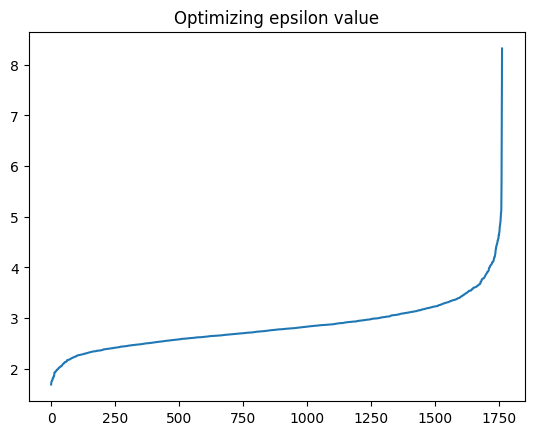

In [245]:
%%time

cluster_dict, dist_dict, labels = cluster_utils.run_clustering(embedded_dict)

In [246]:
#for key, val in dist_dict_2.items():
#    print('dist 1:', dist_dict[key], '\tdist 2:', dist_dict_2[key])

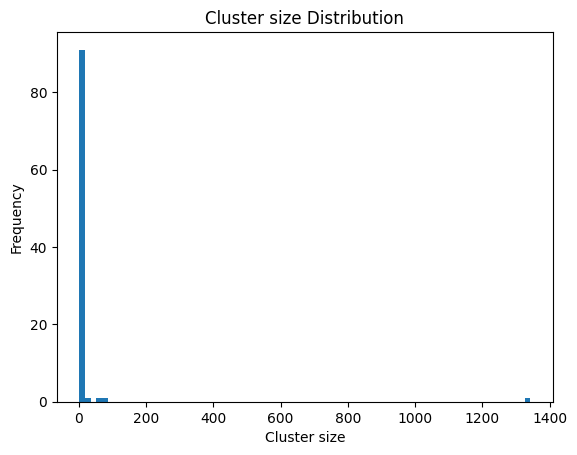

In [247]:
cluster_utils.plot_cluster_size_distribution(cluster_dict)

Plotting tSNE

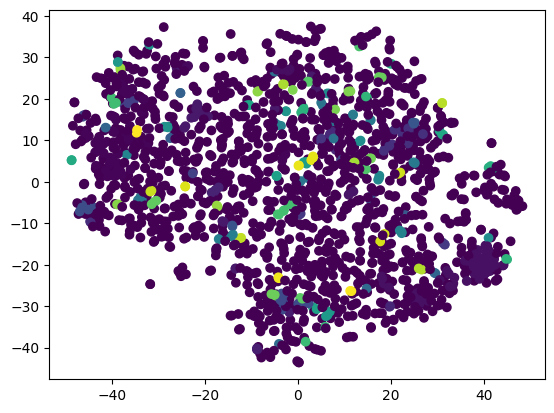

CPU times: total: 52.2 s
Wall time: 16.6 s


In [248]:
%%time
cluster_utils.plot_tsne(embedded_dict, labels)

#### 3.1.2) Using DBSCAN with cosine distance

Testing DBSCAN with cosine metric

eps 0.0821445


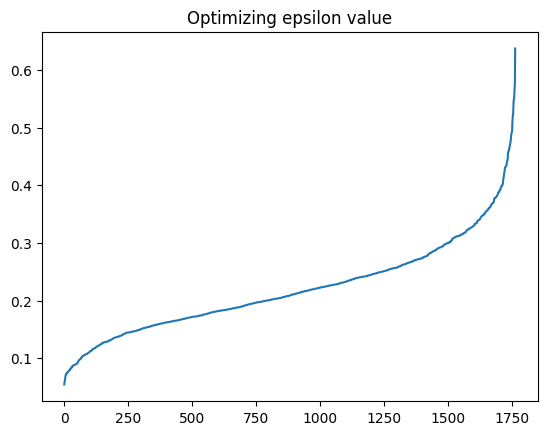

In [249]:
cluster_dict_cos, dist_dict_cos, labels_cos = cluster_utils.run_clustering(embedded_dict, cosine=True)

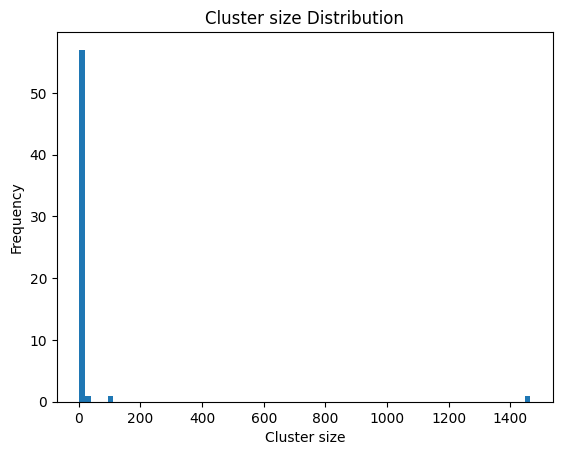

In [250]:
cluster_utils.plot_cluster_size_distribution(cluster_dict_cos)

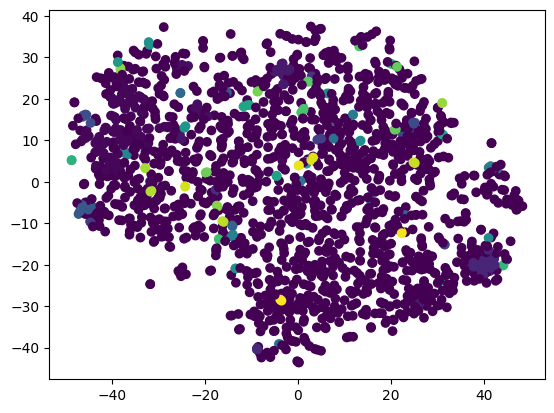

CPU times: total: 53.3 s
Wall time: 17 s


In [251]:
%%time
cluster_utils.plot_tsne(embedded_dict, labels_cos)

#### 3.1.3) Using HDBSCAN with UMAP

In [252]:
cluster_dict_h, dist_dict_h, labels_h = cluster_utils.run_clustering_hdbscan(embedded_dict)

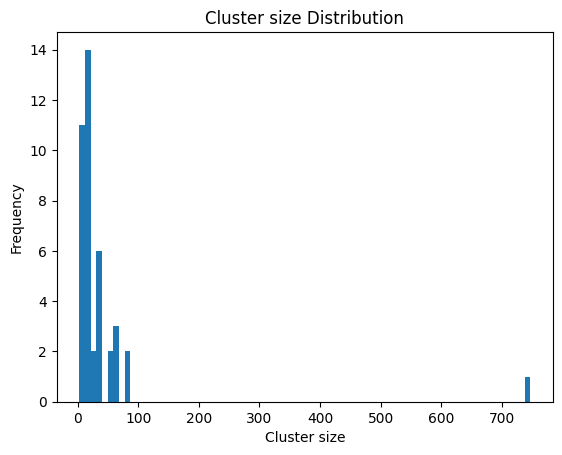

In [253]:
cluster_utils.plot_cluster_size_distribution(cluster_dict_h)

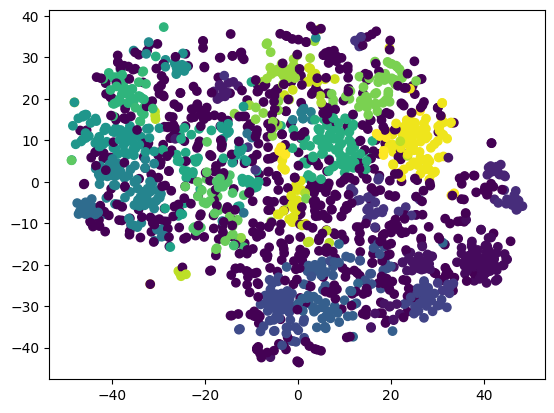

In [254]:
cluster_utils.plot_tsne(embedded_dict, labels_h)

#### 3.1.4) Comapirson

In [255]:
print('Euclidian distance:\t', len(cluster_dict), 'clusters')
print('Cosine distance:\t', len(cluster_dict_cos), 'clusters')
print('HDBSCAN clustering:\t', len(cluster_dict_h), 'clusters')

Euclidian distance:	 95 clusters
Cosine distance:	 60 clusters
HDBSCAN clustering:	 41 clusters


Plotting Jaccard index histogram

In [256]:
test_dict = nlp_utils.create_word_dict(['hi, how are you?', 'I love chocolate', 'I love banana', 'he loves cola'])
test_list = cluster_utils.get_word_list_for_clustering(test_dict)
test_list

['hi', 'banana', 'chocolate', 'cola', 'love']

Getting distance threshold

In [257]:
threshold = cluster_utils.define_max_threshold()
threshold

sim_list_best 0.82521856
sim_list_worst 0.56748897


0.3036462366580963

### 3.2) Replacing words in documents

#### 3.2.1) Based on Eucledian distance

In [258]:
######################### TEMP #######################
#df = df[:30]

Starting average Jaccard index: 0.18490998931057948
Distance threshold: 0.3036462366580963
distance: 0.34762847 the next cluster is too wide and wont be replaced: ['guy', 'trash', 'unless', 'certainly', 'anyone', 'usually', 'absolutely', 'actually', 'waste', 'barely', 'although', 'yeah', 'mostly', 'crazy', 'shame', 'already', 'wtf', 'finally', 'dick', 'surprised', 'damn', 'normally', 'understand', 'twice', 'handle', 'explain', 'mess', 'forget', 'exactly', 'basically', 'almost', 'anyway', 'anymore', 'fool', 'dirty', 'obviously', 'shut', 'definitely', 'unfortunately', 'aware', 'everytime', 'probably', 'therefore', 'totally', 'suppose', 'however', 'garbage', 'maybe', 'kid', 'fault', 'dude', 'possibly', 'something', 'swear', 'really', 'seriously', 'struggle', 'everything', 'strip', 'otherwise', 'anything', 'hardly', 'hell', 'completely', 'apparently', 'simply', 'nasty', 'yesterday', 'beyond', 'remind', 'impressed']
distance: 0.16760047 	replacing ['fabulous', 'lovely', 'wonderful'] in beau

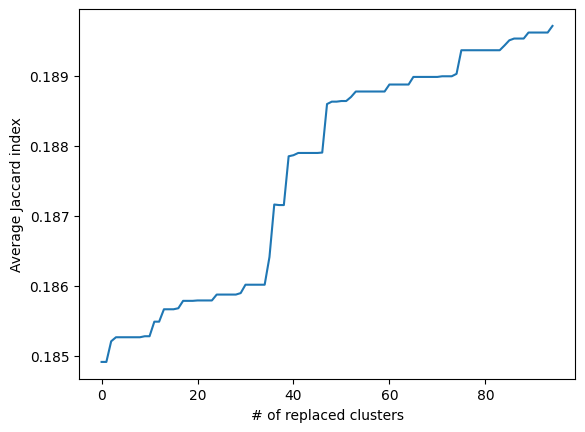

In [260]:
%%time
df_2, word_dict_2 = nlp_utils.replace_words_in_df(df, cluster_dict, dist_dict, threshold, word_dict)

In [261]:
df_2

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...","caution!: (these) {track} (are) (not) (the) (""...",0,6,12,4
1,461,just awful: this was possibly the worst book i...,0,25,just worse : this was possibly the bad book i ...,(just) [worse] (this) (was) possibly (the) {ba...,1,3,18,3
2,493,no lessons learned: this is one of the most di...,0,23,no lesson learn : this is one of the most disa...,(no) {lesson} {learn} (this) (is) (one) (of) (...,1,3,14,5
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) (size)...,0,4,13,4
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size run really small , it shoe up ...","(pass:) (the) {size} (run) really (small,) (it...",0,4,15,6
...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : in-depth delivery . correct part ....,excellent: [in-depth] delivery. (correct) {par...,0,4,12,8
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,purchase minn kota mkp 3 prop from amazon.com ...,{purchase} minn kota mkp 3 prop (from) amazon....,0,3,13,9
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 charger : this charge...,{plantronic} bluetooth 665 charger: (this) cha...,0,2,16,10
944,20784,video purchase: like the movie so i bought it....,1,18,video purchase : like the song so i buy it . r...,video purchase: (like) (the) [song] (so) (i) (...,2,1,10,5


#### 3.2.2) Based on Cosine distance

Starting average Jaccard index: 0.18490998931057948
Distance threshold: 0.3036462366580963
distance: 0.3652509 the next cluster is too wide and wont be replaced: ['guy', 'scary', 'today', 'trash', 'hilarious', 'freakin', 'unless', 'certainly', 'annoying', 'anyone', 'usually', 'absolutely', 'actually', 'waste', 'barely', 'without', 'worth', 'although', 'yeah', 'crazy', 'shame', 'everyone', 'crap', 'trust', 'truth', 'already', 'wtf', 'finally', 'dick', 'surprised', 'damn', 'normally', 'easy', 'understand', 'twice', 'handle', 'explain', 'mess', 'forget', 'exactly', 'basically', 'realize', 'dumb', 'someone', 'awful', 'almost', 'kinda', 'yea', 'anyway', 'anymore', 'fool', 'dirty', 'creepy', 'obviously', 'shut', 'definitely', 'unfortunately', 'nearly', 'hate', 'careful', 'probably', 'totally', 'suppose', 'however', 'garbage', 'maybe', 'ugly', 'kid', 'stupid', 'funny', 'worse', 'fault', 'dude', 'possibly', 'something', 'ridiculous', 'swear', 'really', 'seriously', 'struggle', 'everything', 'o

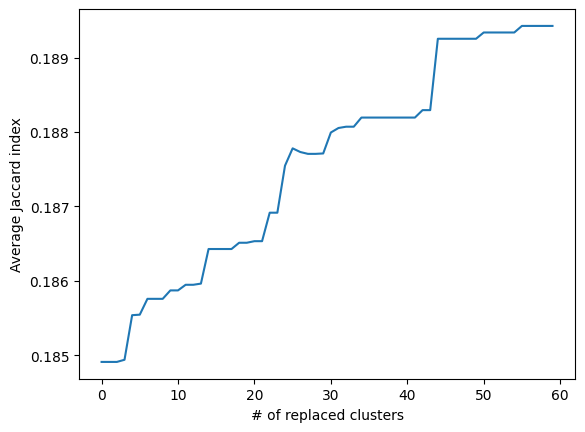

In [262]:
%%time
df_3, word_dict_3 = nlp_utils.replace_words_in_df(df, cluster_dict_cos, dist_dict_cos, threshold, word_dict)

In [263]:
df_3

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...","caution!: (these) {track} (are) (not) (the) (""...",1,6,12,3
1,461,just awful: this was possibly the worst book i...,0,25,just awful : this was possibly the bad book i ...,(just) [worse] (this) (was) possibly (the) {ba...,1,3,18,3
2,493,no lessons learned: this is one of the most di...,0,23,no lesson learn : this is one of the most upse...,(no) {lesson} {learn} (this) (is) (one) (of) (...,2,3,14,4
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) (size)...,0,4,13,4
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size run really small , it shoes up...","(pass:) (the) {size} (run) really (small,) (it...",0,4,15,6
...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : prompt delivery . correct part . y...,excellent: [in-depth] delivery. (correct) {par...,1,4,12,7
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,discount minn kota mkp 3 prop from amazon.com ...,{purchase} minn kota mkp 3 prop (from) amazon....,0,3,13,9
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 lock : this lock is g...,{plantronic} bluetooth 665 [lock] (this) [lock...,2,2,16,8
944,20784,video purchase: like the movie so i bought it....,1,18,video discount : like the song so i buy it . r...,video [discount] (like) (the) [song] (so) (i) ...,3,1,10,4


#### 3.2.3) Based on HDBSCAN clustering

Starting average Jaccard index: 0.18490998931057948
Distance threshold: 0.3036462366580963
distance: 0.36113602 the next cluster is too wide and wont be replaced: ['guy', 'scary', 'huh', 'annoying', 'yeah', 'crazy', 'wtf', 'suck', 'dick', 'damn', 'meh', 'salty', 'dumb', 'bet', 'chill', 'dirty', 'creepy', 'shut', 'sorry', 'ugly', 'kid', 'stupid', 'wow', 'funny', 'dude', 'swear', 'weird', 'hell', 'soo', 'ass', 'nasty', 'wat']
distance: 0.34586146 the next cluster is too wide and wont be replaced: ['imaginative', 'reliable', 'helpful', 'fascinating', 'realistic', 'intriguing', 'inexpensive', 'reasonable', 'energetic', 'profound', 'upbeat', 'informative']
distance: 0.42634168 the next cluster is too wide and wont be replaced: ['shower', 'pet', 'copper', 'bag', 'fireplace', 'junk', 'mug', 'converse', 'holder', 'purple', 'shirt', 'backpack', 'flavor', 'penny', 'cereal', 'delicious', 'sock', 'diet', 'bottle', 'grab', 'pajama', 'mask', 'tank', 'microwave', 'drawer', 'grip', 'sandal', 'flip', '

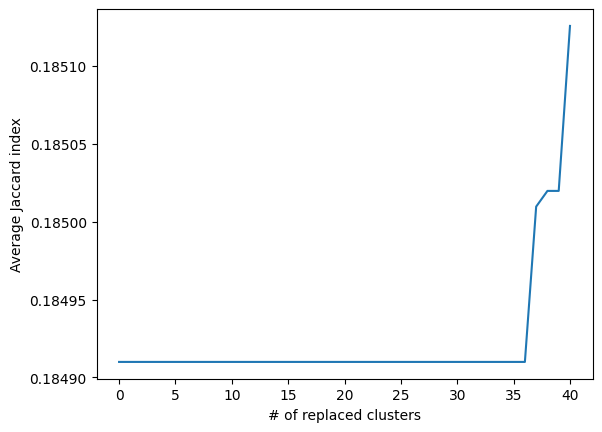

In [264]:
%%time
df_4, word_dict_4 = nlp_utils.replace_words_in_df(df, cluster_dict_h, dist_dict_h, threshold, word_dict)

In [265]:
df_4

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...","caution!: (these) {track} (are) (not) (the) (""...",1,6,12,3
1,461,just awful: this was possibly the worst book i...,0,25,just awful : this was possibly the bad book i ...,(just) [worse] (this) (was) possibly (the) {ba...,1,3,18,3
2,493,no lessons learned: this is one of the most di...,0,23,no lesson learn : this is one of the most disa...,(no) {lesson} {learn} (this) (is) (one) (of) (...,2,3,14,4
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) (size)...,0,4,13,4
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size run really small , it flip up ...","(pass:) (the) {size} (run) really (small,) (it...",0,4,15,6
...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : prompt delivery . correct part . y...,excellent: [in-depth] delivery. (correct) {par...,1,4,12,7
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,purchase minn kota mkp 3 prop from amazon.com ...,{purchase} minn kota mkp 3 prop (from) amazon....,0,3,13,9
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 charger : this charge...,{plantronic} bluetooth 665 [lock] (this) [lock...,2,2,16,8
944,20784,video purchase: like the movie so i bought it....,1,18,video purchase : like the movie so i buy it . ...,video [discount] (like) (the) [song] (so) (i) ...,3,1,10,4


Looking at the histogram again

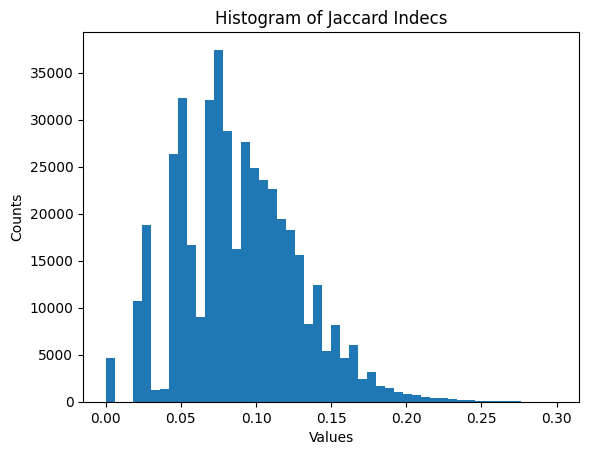

CPU times: total: 6 s
Wall time: 8.11 s


In [266]:
%%time
nlp_utils.plot_jaccard_hist(df_2, column='txt')

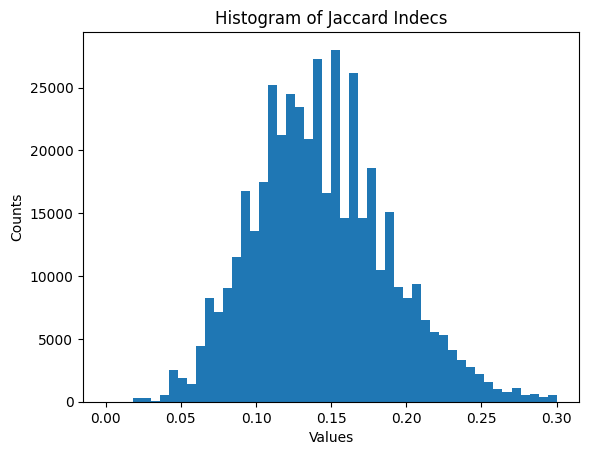

CPU times: total: 6.92 s
Wall time: 10 s


In [267]:
%%time
nlp_utils.plot_jaccard_hist(df_2, 'anon_txt')

For eucledian distance

In [268]:
protected, lemma, replaced, all_words = nlp_utils.get_stat(word_dict_2)
print(f'Protected: {protected}\tLemmatized: {lemma}\t Replaced: {replaced}\t All: {all_words}')

Protected: 678	Lemmatized: 928	 Replaced: 307	 All: 3307


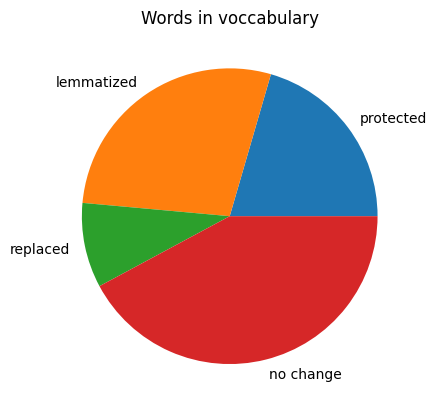

In [269]:
y = np.array([protected, lemma, replaced, (all_words - protected - lemma - replaced)])
mylabels = ['protected', 'lemmatized', 'replaced', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in voccabulary')
plt.show()

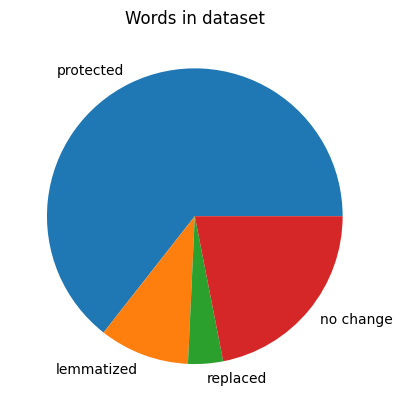

In [270]:
y = np.array([df_2['num_protected'].sum(), df_2['num_lemmatized'].sum(), df_2['num_replaced'].sum(), df_2['num_no_change'].sum()])
mylabels = ['protected', 'lemmatized', 'replaced', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

## 4) Force anonymity

### Get anonymity degree

Before replacement

In [271]:
curr_k, non_anon_indexes = anonym_utils.get_anonym_degree(docs=df_2['txt'])
print('Current k:', curr_k, '\tnumber of un-anonym. documents:', len(non_anon_indexes), '\tnumber of all documents:', len(df_2['txt']))

Current k: 1 	number of un-anonym. documents: 944 	number of all documents: 946


After replacement

In [272]:
curr_k, non_anon_indexes = anonym_utils.get_anonym_degree(docs=df_2['anon_txt'])
print('Current k:', curr_k, '\tnumber of un-anonym. documents:', len(non_anon_indexes), '\tnumber of all documents:', len(df_2['anon_txt']))

Current k: 1 	number of un-anonym. documents: 944 	number of all documents: 946


### Steps:
1. Finding k nearest neighbors using approximate nearest neighbors
2. Finding the different words between the neighbors
2. Replacing the different words with *

In [273]:
anonym_utils.delete_uncommon_words(['I love choco', 'I love banana'])


['I love *', 'I love *']

In [274]:
anonym_utils.force_anonym_using_annoy(['I love choco', 'I love banana', 'lalala'], k=2)

Start: get_anonym_degree: 1
similar_doc_ind [0, 1]
Breaking after moving over 2 of all 3 indexes.
unused_indexes: [2]
End: get_anonym_degree: 1


['I love *', 'I love *', '*']

In [275]:
force_anon_txt_annoy = anonym_utils.force_anonym_using_annoy(df_2['anon_txt'], k=2)
anonym_utils.get_anonym_degree(force_anon_txt_annoy)

Start: get_anonym_degree: 1
similar_doc_ind [0, 298]
similar_doc_ind [1, 265]
similar_doc_ind [2, 754]
similar_doc_ind [3, 246]
similar_doc_ind [4, 534]
similar_doc_ind [5, 6]
similar_doc_ind [7, 424]
similar_doc_ind [8, 117]
similar_doc_ind [9, 540]
similar_doc_ind [10, 12]
similar_doc_ind [11, 369]
similar_doc_ind [13, 384]
similar_doc_ind [14, 920]
similar_doc_ind [15, 314]
similar_doc_ind [16, 231]
similar_doc_ind [17, 907]
similar_doc_ind [18, 653]
similar_doc_ind [19, 370]
similar_doc_ind [20, 213]
similar_doc_ind [21, 355]
similar_doc_ind [22, 685]
similar_doc_ind [23, 166]
similar_doc_ind [24, 425]
similar_doc_ind [25, 372]
similar_doc_ind [26, 140]
similar_doc_ind [27, 403]
similar_doc_ind [28, 143]
similar_doc_ind [29, 77]
similar_doc_ind [30, 530]
similar_doc_ind [31, 159]
similar_doc_ind [32, 255]
similar_doc_ind [33, 287]
similar_doc_ind [34, 48]
similar_doc_ind [35, 40]
similar_doc_ind [36, 615]
similar_doc_ind [37, 590]
similar_doc_ind [38, 501]
similar_doc_ind [39, 436]

(1, [[320], [401], [705], [693], [902], [916]])

In [276]:
curr_k, non_anon_indexes = anonym_utils.get_anonym_degree(force_anon_txt_annoy)
print('Current k:', curr_k, '\tnumber of un-anonym. documents:', len(non_anon_indexes), '\tnumber of all documents:', len(df_2['txt']))

Current k: 1 	number of un-anonym. documents: 6 	number of all documents: 946


In [277]:
df_2['force_anon_txt'] = force_anon_txt_annoy
# Counting the number of words and *
df_2['num_of_words_after_forcing'] = df_2['force_anon_txt'].apply(lambda x: len(re.findall(r'\w+', x)))
df_2['num_of_deleting_after_forcing'] = df_2['force_anon_txt'].apply(lambda x: len(re.findall(r'\*', x)))

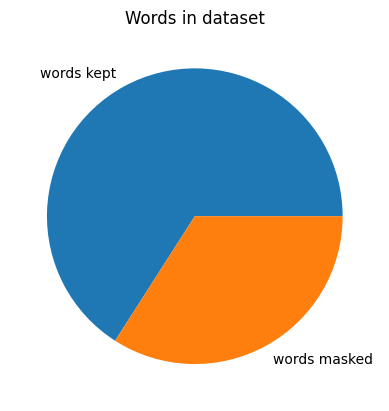

In [278]:
y = np.array([df_2['num_of_words_after_forcing'].sum(), df_2['num_of_deleting_after_forcing'].sum()])
mylabels = ['words kept', 'words masked']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

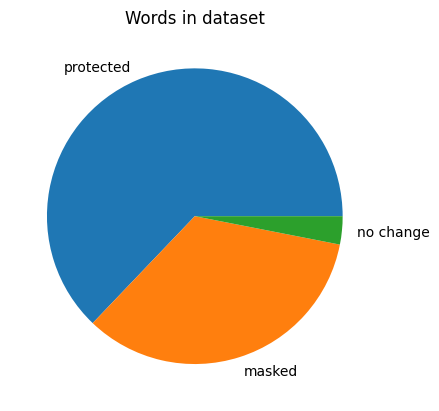

In [279]:
y = np.array([df_2['num_protected'].sum(), df_2['num_of_deleting_after_forcing'].sum(), (df_2['num_of_words_after_forcing'] - df_2['num_protected']).sum()])
mylabels = ['protected', 'masked', 'no change']

plt.pie(y, labels = mylabels)
plt.title('Words in dataset')
plt.show()

In [280]:
i = 1
print(df_2['txt'][i])
print(df_2['anon_txt_history'][i])
print(df_2['force_anon_txt'][i])

just awful: this was possibly the worst book i have ever read. i am amazed by the number of fans for this kind of rubbish.
(just) [worse] (this) (was) possibly (the) {bad} (book) (i) (have) (ever) (read.) (i) (am) {amaze} (by) (the) (number) (of) {fan} (for) (this) (kind) (of) rubbish. 
just * : this was * the bad book i have ever read . i am * by the * of * for this * of * .


## 5) Utilization tests

In [281]:
df_21 = utilization_utils.get_vader_sentiment_for_df(df_2, ['txt', 'anon_txt', 'force_anon_txt'])
df_21

,Unnamed: 0,txt,sentiment,num_of_words,anon_txt,anon_txt_history,num_replaced,num_lemmatized,num_protected,num_no_change,force_anon_txt,num_of_words_after_forcing,num_of_deleting_after_forcing,txt_vader_sentiment_pred,anon_txt_vader_sentiment_pred,force_anon_txt_vader_sentiment_pred
0,99,"caution!: these tracks are not the ""original"" ...",0,22,"caution ! : these track are not the "" original...","caution!: (these) {track} (are) (not) (the) (""...",0,6,12,4,"* ! : these * are not the "" original "" version...",17,6,0.0000,-0.1957,-0.1957
1,461,just awful: this was possibly the worst book i...,0,25,just worse : this was possibly the bad book i ...,(just) [worse] (this) (was) possibly (the) {ba...,1,3,18,3,just * : this was * the bad book i have ever r...,18,7,-0.5574,-0.2023,-0.5423
2,493,no lessons learned: this is one of the most di...,0,23,no lesson learn : this is one of the most disa...,(no) {lesson} {learn} (this) (is) (one) (of) (...,1,3,14,5,no lesson * : this is one of * most * * i have...,13,11,-0.5563,-0.5563,-0.2960
3,578,squeem: i ordered according to the size chart ...,0,21,squeem : i order accord to the size chart for ...,squeem: (i) {order} {accord} (to) (the) (size)...,0,4,13,4,* : i order * to the size * for my * and it wa...,16,6,0.0000,0.0000,0.0000
4,595,"pass: the sizes run really small, it flips up ...",0,25,"pass : the size run really small , it shoe up ...","(pass:) (the) {size} (run) really (small,) (it...",0,4,15,6,"* : the size * * * , it shoe up * * , they * i...",16,10,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,20710,excellent: prompt delivery. correct parts. you...,1,24,excellent : in-depth delivery . correct part ....,excellent: [in-depth] delivery. (correct) {par...,0,4,12,8,excellent : in - * * . * * . you can not do * ...,16,10,0.8622,0.8313,0.7712
942,20711,purchased minn kota mkp 3 prop from amazon.com...,1,25,purchase minn kota mkp 3 prop from amazon.com ...,{purchase} minn kota mkp 3 prop (from) amazon....,0,3,13,9,* * * * 3 * from *.* . : the * was * what i * ...,14,12,0.0000,0.0000,0.0000
943,20738,plantronics bluetooth 665 charger: this charge...,1,28,plantronic bluetooth 665 charger : this charge...,{plantronic} bluetooth 665 charger: (this) cha...,0,2,16,10,* * * * : this * is great for time when you do...,19,10,0.7841,0.7841,0.7650
944,20784,video purchase: like the movie so i bought it....,1,18,video purchase : like the song so i buy it . r...,video purchase: (like) (the) [song] (so) (i) (...,2,1,10,5,* * : like the song so i * it . * the hd in * ...,11,7,0.8655,0.8655,0.3612


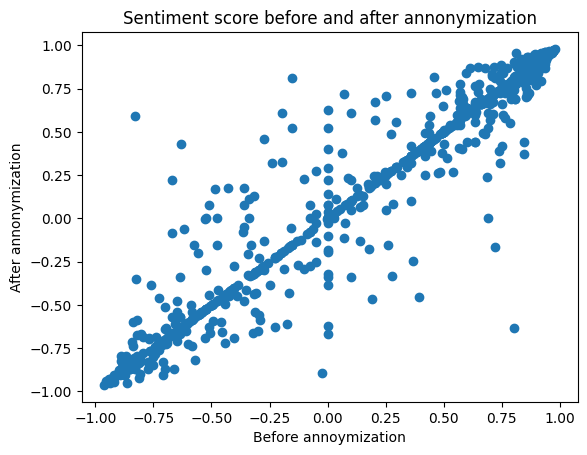

In [282]:
import matplotlib.pyplot as plt

plt.scatter(df_21['txt_vader_sentiment_pred'], df_21['anon_txt_vader_sentiment_pred'])
plt.xlabel('Before annoymization')
plt.ylabel('After annonymization')
plt.title('Sentiment score before and after annonymization');


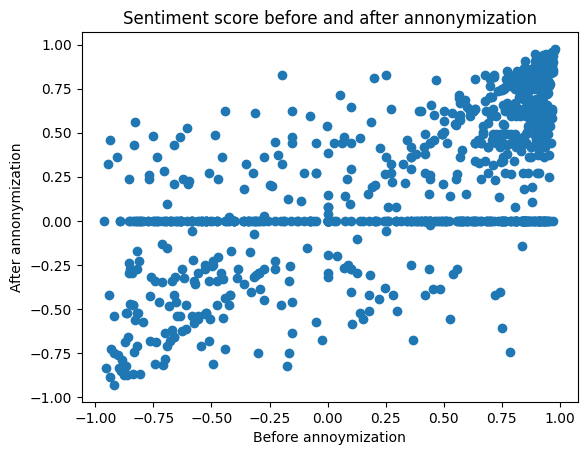

In [283]:
plt.scatter(df_21['txt_vader_sentiment_pred'], df_21['force_anon_txt_vader_sentiment_pred'])
plt.xlabel('Before annoymization')
plt.ylabel('After annonymization')
plt.title('Sentiment score before and after annonymization');


### Using Naive Bayes

In [284]:
utilization_utils.sentiment_test(df_2, 'txt')

0.8858246688505911

In [285]:
utilization_utils.sentiment_test(df_2, 'anon_txt')

0.8762996724113374

The fully anonymized text gets he highest accuracy score!

In [286]:
utilization_utils.sentiment_test(df_2, 'force_anon_txt')

0.7863997293832787

### Using XGBoost

In [287]:
utilization_utils.sentiment_test(df_2, 'txt')

0.8858246688505911

In [288]:
utilization_utils.sentiment_test(df_2, 'anon_txt')

0.8762996724113374

In [289]:
utilization_utils.sentiment_test(df_2, 'force_anon_txt')

0.7863997293832787

## Saving output

In [290]:
filename = 'outputs/' + output_name
df_2.to_csv(filename, index=False)

### Temp and tries

In [291]:
print(nlp_utils.stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [292]:
len(nlp_utils.stopwords.words('english'))

179

In [293]:
len(nlp_utils.stopword_list)

179

In [294]:
nlp_utils.add_word_list_to_stop_words('data/1000_most_common_words.txt')
len(nlp_utils.stopword_list)

1075